In [20]:
import os
import re
import PIL
import sys
import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix,accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [21]:
data_dir = '/home/linh/Downloads/DeepWeeds'

valid_dir = data_dir + "/test_5" #'/NCT-CRC-HE-100K-NONORM' 

# Define your transforms for the training and testing sets
data_transforms = {  
    'test_5':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test_5']}

# Using the image datasets and the trainforms, define the data_loader
# batch_size = 64 for B0, B1, B2, B3; batch_size = 32 for B4; batch_size = 16 for B5
# batch_size = 8 for B6, B7
batch_size = 8
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['test_5']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test_5']}

class_names = image_datasets['test_5'].classes

print(dataset_sizes)
print(device)

"""# Label mapping
with open('/home/linh/Downloads/CRC/cat_to_name_7K.json', 'r') as f:
    cat_to_name = json.load(f)"""

'''f = open('/home/linh/Downloads/Derma/classes.txt','r')
cat_to_name = f.read()
print(cat_to_name)
f.close()    
'''
### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test_5'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}

    
# Run this to test the data loader
images, labels = next(iter(data_loader['test_5']))
images.size()

{'test_5': 3502}
cuda:0


torch.Size([8, 3, 224, 224])

In [22]:
CLASSES = os.listdir(valid_dir)
CLASSES

['Siam weed',
 'Negative',
 'Lantana',
 'Parkinsonia',
 'Parthenium',
 'Prickly acacia',
 'Chinee apple',
 'Snake weed',
 'Rubber vine']

In [43]:

#model = timm.create_model('tf_efficientnet_b4_ap', pretrained=True)
#model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
model = geffnet.create_model('efficientnet_b4', pretrained=True)

# Create classifier
for param in model.parameters():
    param.requires_grad = True
#n_classes = 9
#model.classifier = nn.Linear(model.classifier.in_features, n_classes)

criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model.to(device)
model.class_to_idx = image_datasets['test_5'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

=> Warning: Pretrained model URL is empty, using random initialization.


[(0, 'Chinee apple'),
 (1, 'Lantana'),
 (2, 'Negative'),
 (3, 'Parkinsonia'),
 (4, 'Parthenium'),
 (5, 'Prickly acacia'),
 (6, 'Rubber vine'),
 (7, 'Siam weed'),
 (8, 'Snake weed')]

In [24]:
idx_to_class ={val: key for key, val in model.class_to_idx.items()}
idx_to_class

{0: 'Chinee apple',
 1: 'Lantana',
 2: 'Negative',
 3: 'Parkinsonia',
 4: 'Parthenium',
 5: 'Prickly acacia',
 6: 'Rubber vine',
 7: 'Siam weed',
 8: 'Snake weed'}

In [25]:
list(model.class_to_idx.items())

[('Chinee apple', 0),
 ('Lantana', 1),
 ('Negative', 2),
 ('Parkinsonia', 3),
 ('Parthenium', 4),
 ('Prickly acacia', 5),
 ('Rubber vine', 6),
 ('Siam weed', 7),
 ('Snake weed', 8)]

In [26]:
model.class_to_idx.items()

dict_items([('Chinee apple', 0), ('Lantana', 1), ('Negative', 2), ('Parkinsonia', 3), ('Parthenium', 4), ('Prickly acacia', 5), ('Rubber vine', 6), ('Siam weed', 7), ('Snake weed', 8)])

checkpoint loaded
prediction time for complete in 16107 milisecond
              precision    recall  f1-score   support

           0   0.898678  0.906667  0.902655       225
           1   0.870833  0.981221  0.922737       213
           2   0.962564  0.931906  0.946987      1821
           3   0.990291  0.990291  0.990291       206
           4   0.979592  0.941176  0.960000       204
           5   0.982857  0.807512  0.886598       213
           6   0.813765  0.995050  0.895323       202
           7   0.958333  0.962791  0.960557       215
           8   0.814655  0.931034  0.868966       203

    accuracy                       0.935180      3502
   macro avg   0.919063  0.938627  0.926013      3502
weighted avg   0.939321  0.935180  0.935626      3502



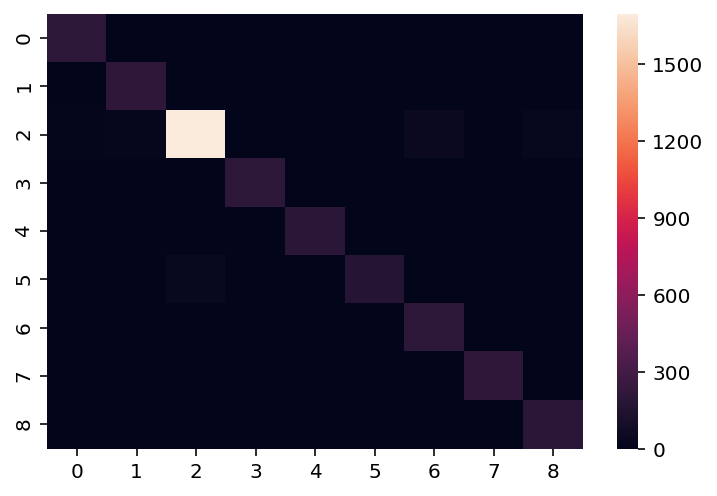

In [44]:
CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_AP_ADAM.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_NS_ADAM.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_AP_ADAM.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
#calculate time for prediction
#set start time to predict
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['test_5']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
'''
for images, labels in data_loader['test_0']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())'''

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/DeepWeeds/results/EfficientNet_Lite_4_ADAM_WWhole_dataset.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/DeepWeeds/results/EfficientNet_Lite_4_ADAM_test_5.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=6)
print(report)